# Chronos - Basic Usage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from chronos import Chronos

import chronos_plotting

In [2]:
my_df = pd.DataFrame({"ds": pd.date_range(start="2016-01-01", periods=365*4, freq='d'),
                      "y": 0.01*np.array(range(365*4)) + np.sin(np.array(range(365*4))/30)})
print(my_df.head())

          ds         y
0 2016-01-01  0.000000
1 2016-01-02  0.043327
2 2016-01-03  0.086617
3 2016-01-04  0.129833
4 2016-01-05  0.172939


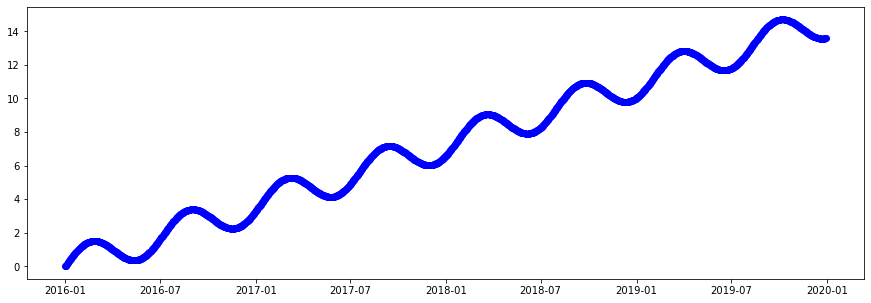

In [3]:
plt.figure(figsize=(15,5))
plt.scatter(my_df['ds'], my_df['y'], c="blue")
plt.show()

In [4]:
my_chronos = Chronos()
my_chronos.fit(my_df)

Employing Maximum A Posteriori
100.0% - ELBO loss: -2.4531 | Mean Absolute Error: 0.2296                                           


In [5]:
predictions = my_chronos.predict(sample_number=1000, period=31)

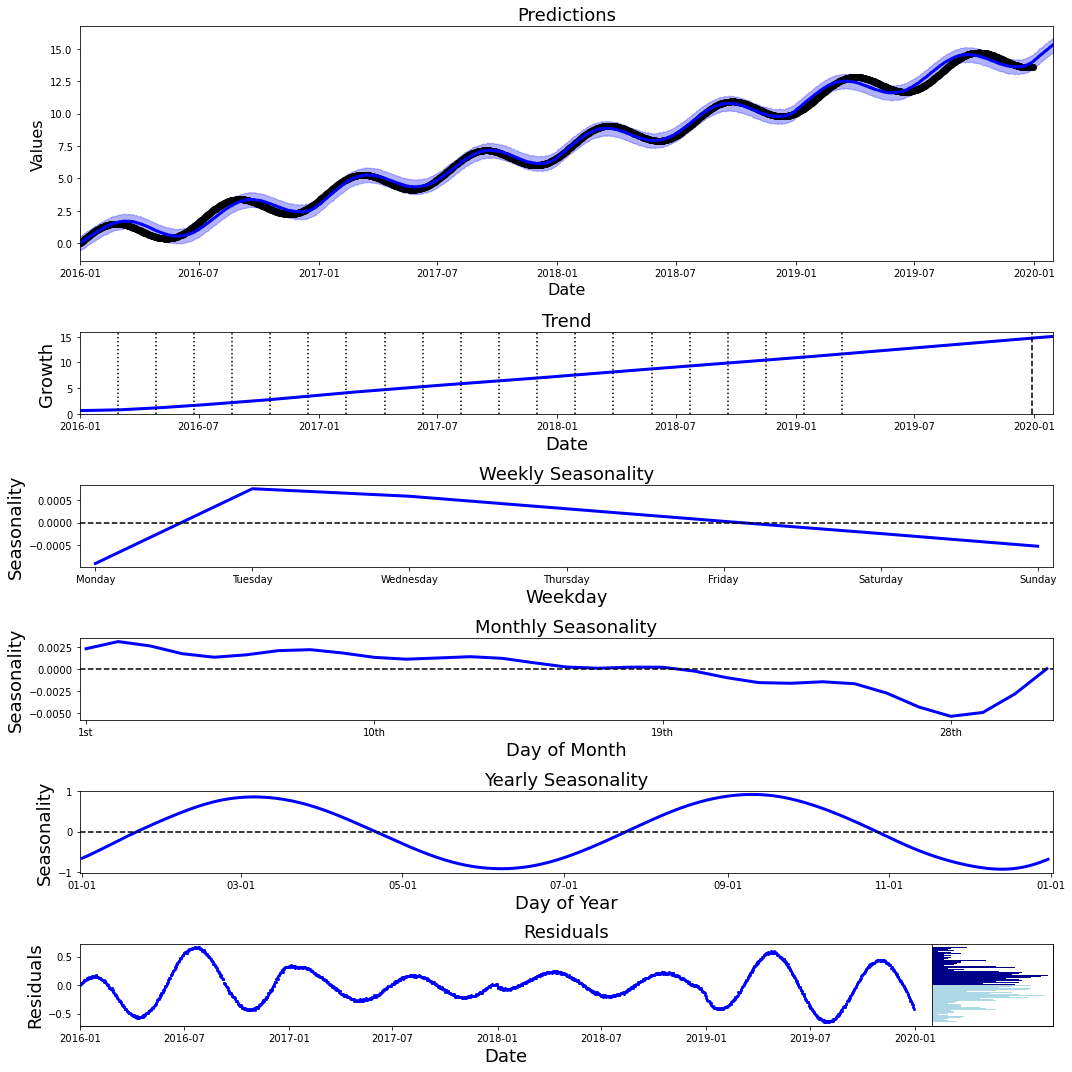

In [6]:
chronos_plotting.plot_components(predictions, my_chronos);

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [8]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [9]:
my_ts_data.shape

(2905, 2)

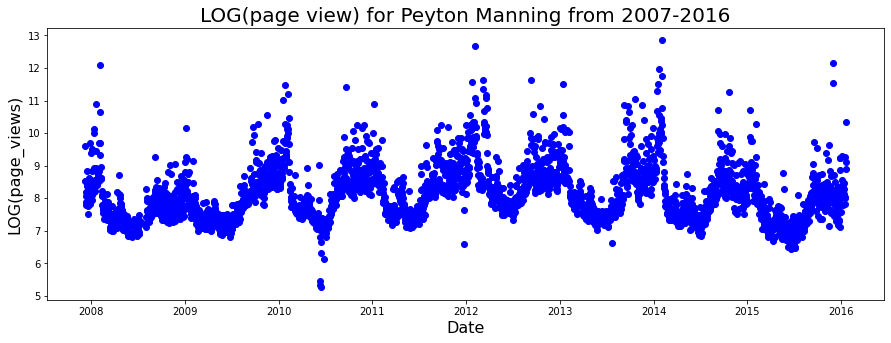

In [10]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [11]:
from chronos import Chronos
import chronos_plotting

In [12]:
my_chronos = Chronos(method="MAP", 
                     max_iter=1000, 
                     learning_rate=0.001,
                     distribution="StudentT", 
                     seasonality_mode="add")
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.9346 | Mean Absolute Error: 0.3376                                           


In [13]:
future_df = my_chronos.make_future_dataframe(period=365)

In [14]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2007-12-10,9.590761,8.339692,9.545191,7.328899,7.615209,7.615209,7.615209
1,2007-12-11,8.519590,8.258591,9.297134,7.254732,7.615547,7.615583,7.615583
2,2007-12-12,8.183677,8.136589,9.174653,7.091331,7.615989,7.615957,7.615957
3,2007-12-13,8.072467,8.049688,9.005603,6.844581,7.616316,7.616330,7.616330
4,2007-12-14,7.893572,8.054624,9.047489,7.028716,7.616757,7.616703,7.616703


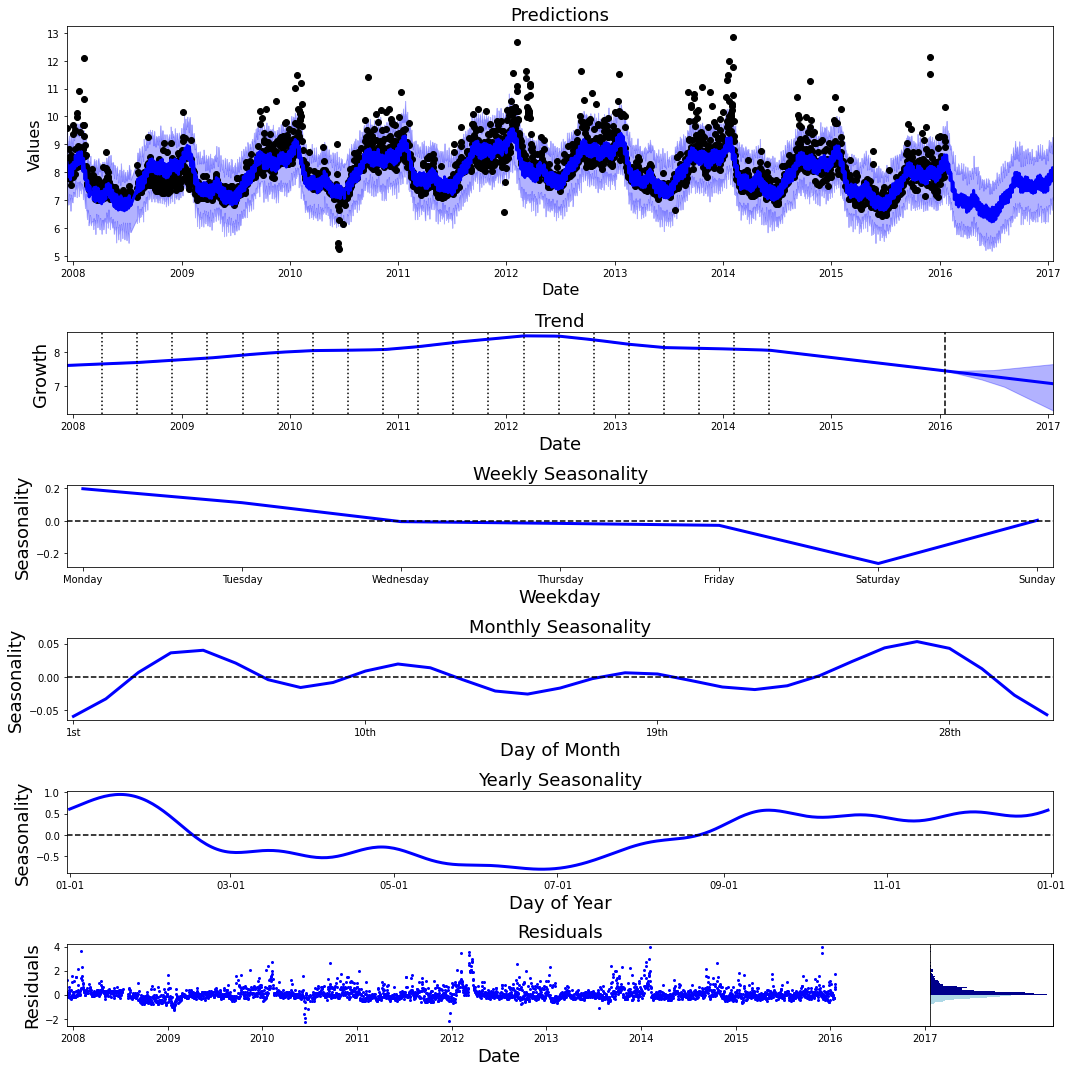

In [15]:
chronos_plotting.plot_components(predictions, my_chronos);

Chronos object not provided, seasonalities will not be plotted
No Chronos object provided, assuming timestamp and target columns are named 'ds' and 'y'.
No Chronos object provided, assuming timestamp and target columns are named 'ds' and 'y'.
Additionally, changepoints will not be labeled on the plot
No Chronos object provided, assuming timestamp and target columns are named 'ds' and 'y'.


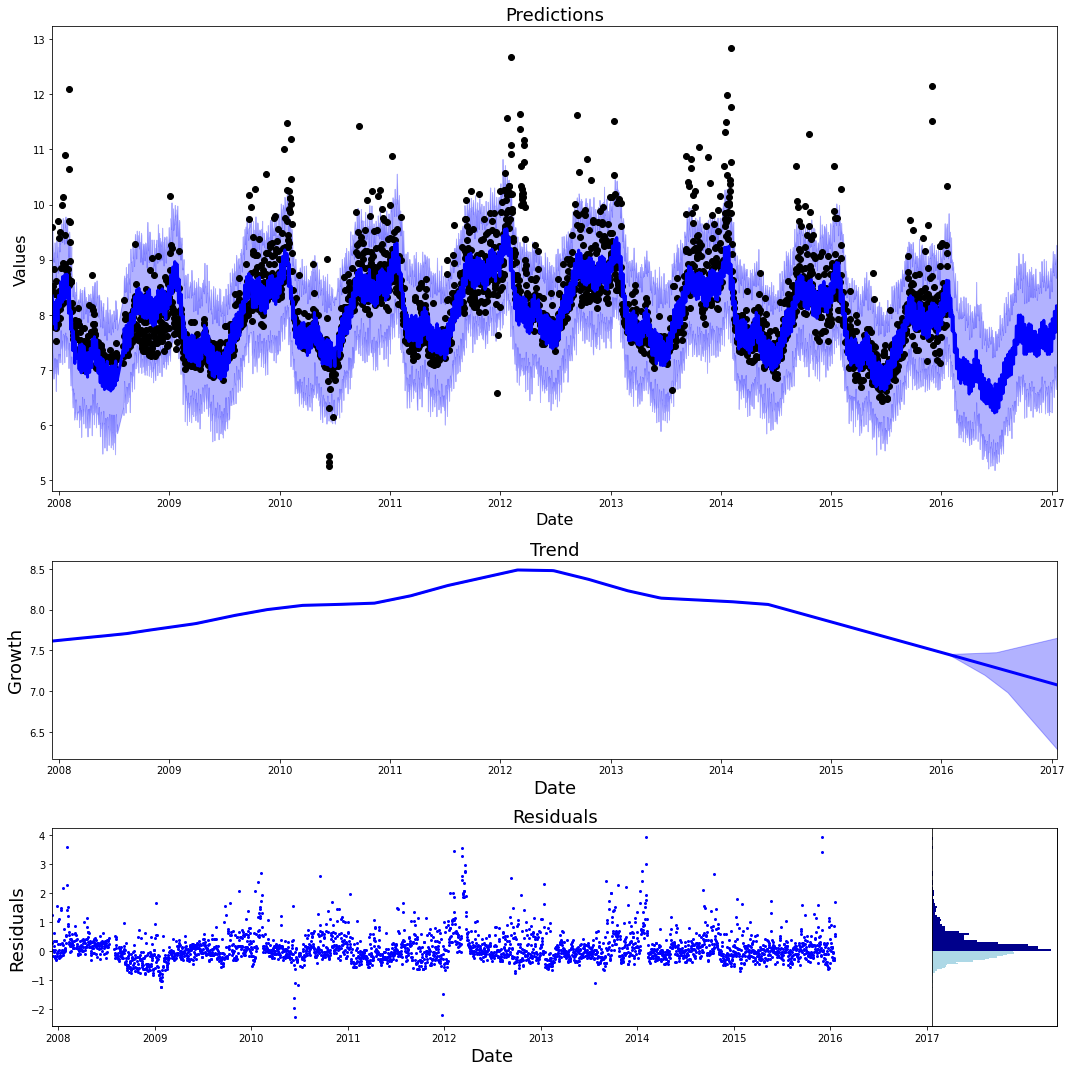

In [16]:
chronos_plotting.plot_components(predictions);

In [17]:
#assert(False)

## Bike Sharing Data

Coming from Chicago: https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data?select=data.csv

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from chronos import Chronos
import chronos_plotting

In [19]:
bike_data = pd.read_csv('data/data.csv')
bike_data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [20]:
relevant_data = bike_data[['starttime', 'trip_id']]
relevant_data['starttime'] = pd.to_datetime(relevant_data['starttime'])
relevant_data

<ipython-input-20-c947c196978f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['starttime'] = pd.to_datetime(relevant_data['starttime'])


,starttime,trip_id
0,2014-06-30 23:57:00,2355134
1,2014-06-30 23:56:00,2355133
2,2014-06-30 23:33:00,2355130
3,2014-06-30 23:26:00,2355129
4,2014-06-30 23:16:00,2355128
...,...,...
9495230,2017-10-01 00:01:00,16734072
9495231,2017-10-01 00:01:00,16734071
9495232,2017-10-01 00:01:00,16734070
9495233,2017-10-01 00:00:00,16734067


In [21]:
relevant_data['date'] = relevant_data['starttime'].dt.date
relevant_data.head()

<ipython-input-21-8522f6141ff6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['date'] = relevant_data['starttime'].dt.date


,starttime,trip_id,date
0,2014-06-30 23:57:00,2355134,2014-06-30
1,2014-06-30 23:56:00,2355133,2014-06-30
2,2014-06-30 23:33:00,2355130,2014-06-30
3,2014-06-30 23:26:00,2355129,2014-06-30
4,2014-06-30 23:16:00,2355128,2014-06-30


In [22]:
grouped_data = relevant_data.groupby('date').sum().reset_index()
grouped_data.columns = ['ds', 'y']
grouped_data['ds'] = pd.to_datetime(grouped_data['ds'])
grouped_data.head()

,ds,y
0,2014-01-01,105421324
1,2014-01-02,123221770
2,2014-01-03,6662107
3,2014-01-04,201035389
4,2014-01-05,35549270


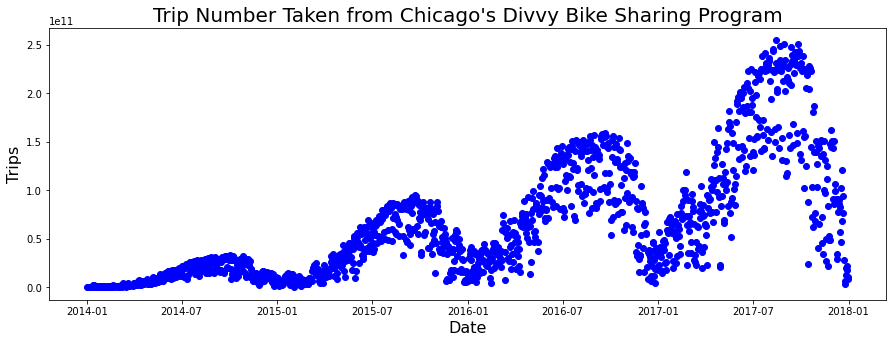

In [23]:
plt.figure(figsize=(15,5))
plt.scatter(grouped_data['ds'], grouped_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Trips", size=16)
plt.title(f"Trip Number Taken from Chicago's Divvy Bike Sharing Program", size=20)
plt.show()

In [24]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.01, 
                     n_changepoints=25,
                     changepoint_range=0.8,
                     changepoint_prior_scale=0.1,
                     distribution="Gamma",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.593 | Mean Absolute Error: 11024922624.0000                                  


In [25]:
predictions = my_chronos.predict(sample_number=1000, frequency='D', ci_interval=0.95, period=365)

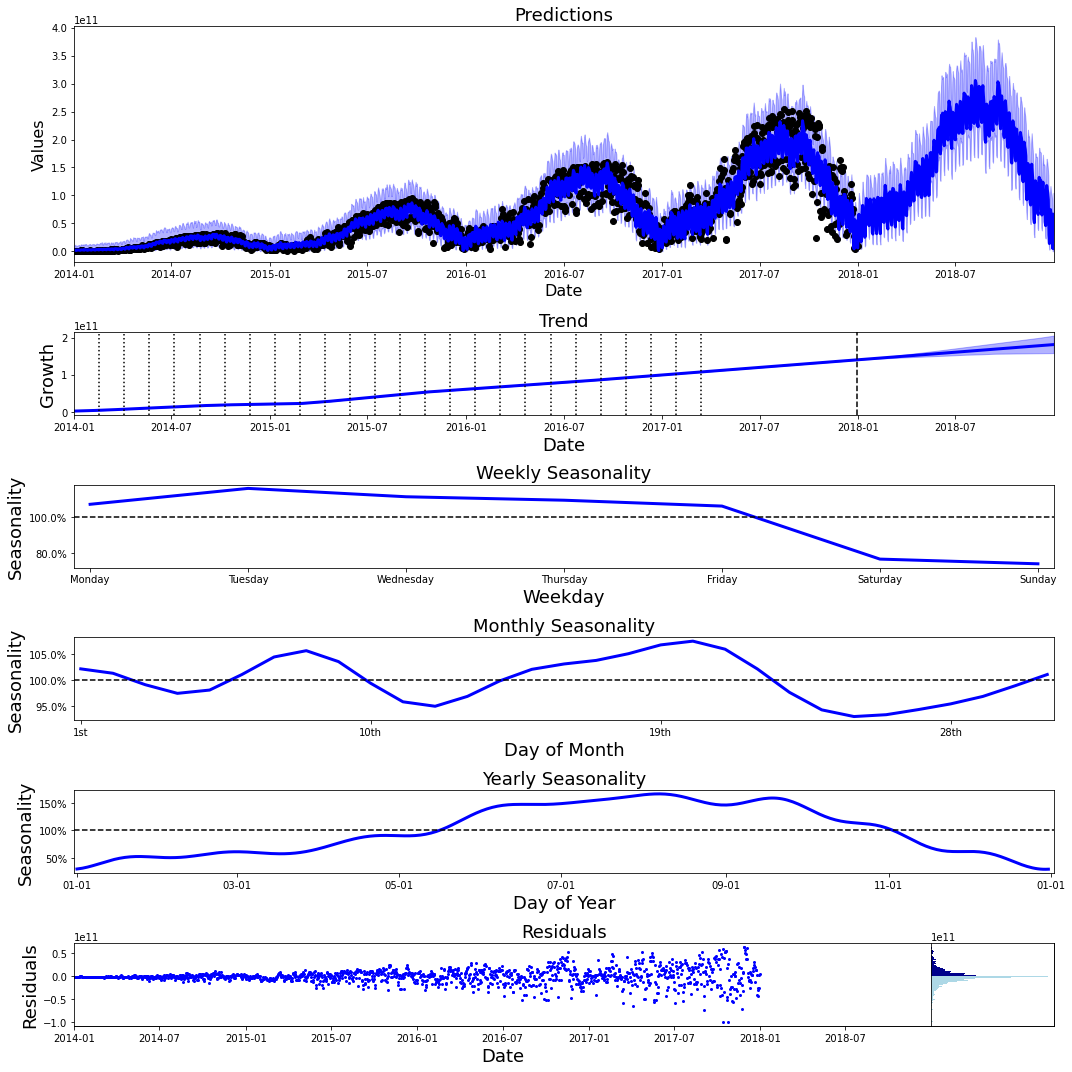

In [26]:
chronos_plotting.plot_components(predictions, 
                                 my_chronos, 
                                 changepoint_threshold=0.0, 
                                 figure_name="Divvy components.png");

No Chronos object provided, assuming timestamp and target columns are named 'ds' and 'y'.


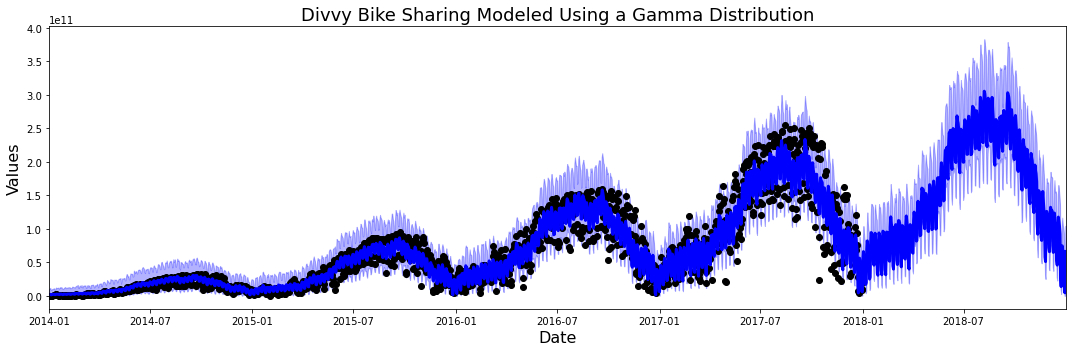

In [27]:
fig = plt.figure(tight_layout=True, figsize=(15,5))
gs = gridspec.GridSpec(1, 1)
chronos_plotting.plot_predictions(predictions, fig=fig, gs_section=gs[0, :])
plt.title("Divvy Bike Sharing Modeled Using a Gamma Distribution", size=18)
plt.show();

In [28]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior_scale=0.1,
                     distribution="Normal",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.2814 | Mean Absolute Error: 10640456704.0000                                 


In [29]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=365)

No Chronos object provided, assuming timestamp and target columns are named 'ds' and 'y'.


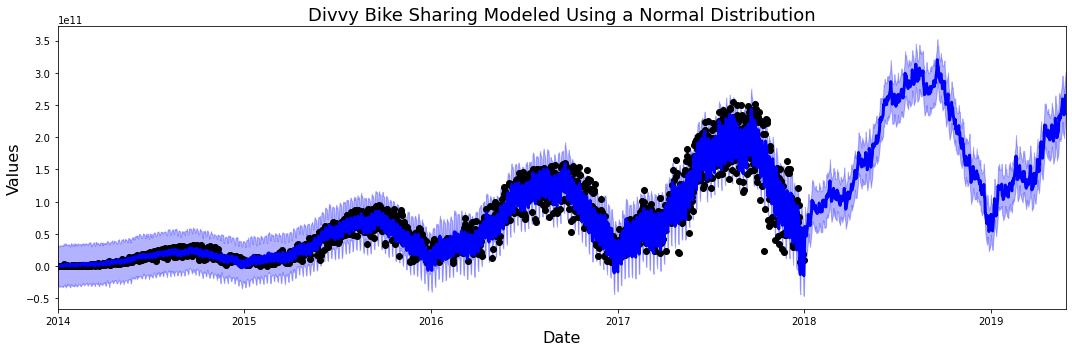

In [30]:
fig = plt.figure(tight_layout=True, figsize=(15,5))
gs = gridspec.GridSpec(1, 1)
chronos_plotting.plot_predictions(predictions, fig=fig, gs_section=gs[0, :])
plt.title("Divvy Bike Sharing Modeled Using a Normal Distribution", size=18)
plt.show();

## COVID

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [32]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,numdeaths_last14,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,35,Ontario,Ontario,2020-01-31,3,0,0.0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,British Columbia,Colombie-Britannique,2020-01-31,1,0,0.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#canada_mask = covid_data['prname'] == 'British Columbia'
canada_mask = covid_data['prname'] == 'Ontario'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

,date,numtoday
0,2020-01-31,3
3,2020-02-08,0
6,2020-02-16,0
9,2020-02-21,0
12,2020-02-24,1


In [34]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
#canada_daily_covid['y'] /= canada_daily_covid['y'].max()
canada_daily_covid = canada_daily_covid[canada_daily_covid['y']> 0]
canada_daily_covid.head()


,ds,y
0,2020-01-31,3
12,2020-02-24,1
18,2020-02-26,1
21,2020-02-27,1
24,2020-02-29,2


In [35]:
canada_daily_covid['y']

0          3
12         1
18         1
21         1
24         2
        ... 
4411    2142
4426    2005
4441    1939
4456    2553
4471    2923
Name: y, Length: 300, dtype: int64

In [36]:
canada_daily_covid['ds'].dt.day_name().isin(["Sunday", "Saturday"]).sum()/canada_daily_covid['ds'].shape[0]

0.2833333333333333

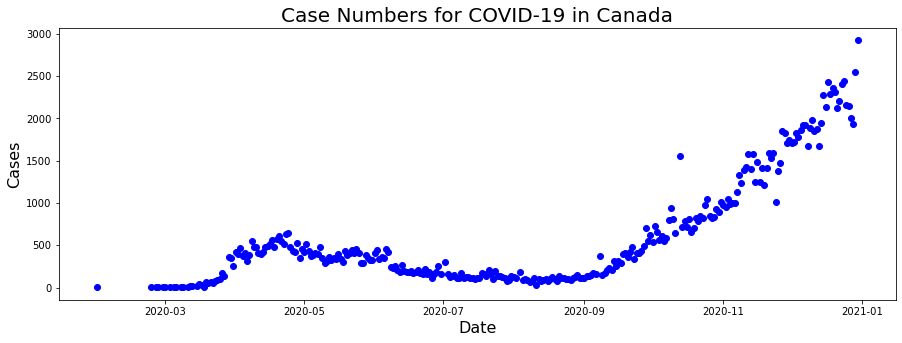

In [37]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [38]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.001, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior_scale=10.0,
                     distribution="Gamma",
                     seasonality_mode="mul",
                     year_seasonality_order=0,
                     weekly_seasonality_order=6,
                     month_seasonality_order=0)#, weekly_seasonality_order=0, month_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.9096 | Mean Absolute Error: 67.5166                                          


In [39]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=60)

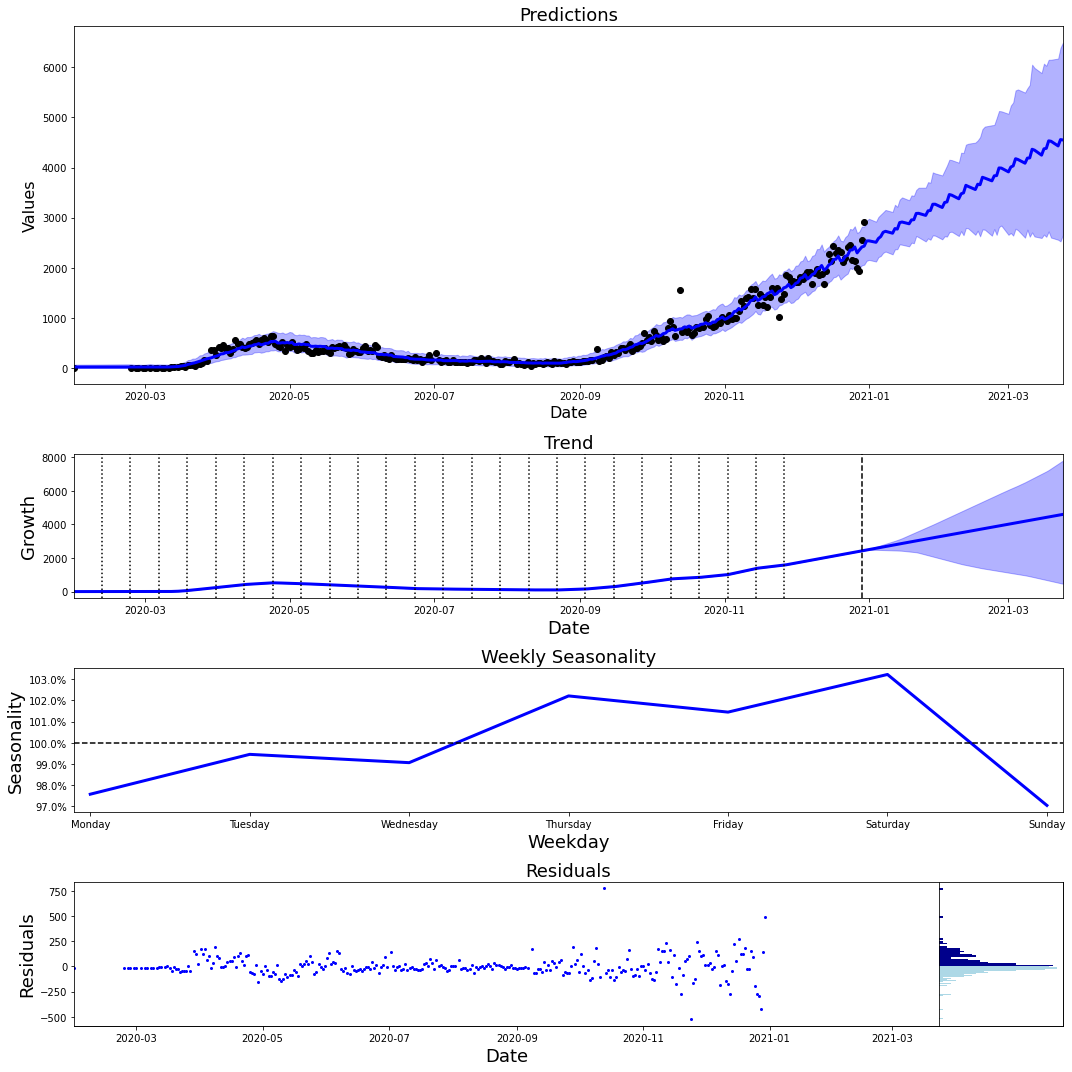

In [40]:
chronos_plotting.plot_components(predictions, my_chronos, changepoint_threshold=0.0, figure_name="COVID components.png");

## AAPL stocks

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos
import chronos_plotting

In [42]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561


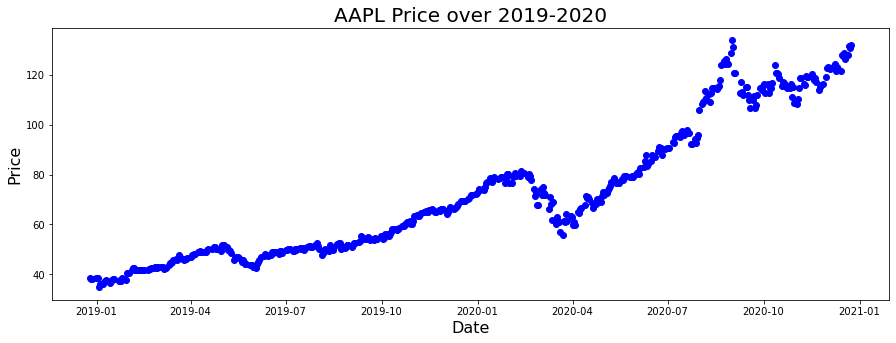

In [43]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [44]:
my_chronos = Chronos(method="MLE", max_iter=2000, 
                     learning_rate=0.0001, 
                     n_changepoints=25,
                     seasonality_mode="mul",
                     distribution="StudentT",
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

No weekends found in training data, will only consider Monday - Friday
Employing Maximum Likelihood Estimation
100.0% - ELBO loss: -2.3695 | Mean Absolute Error: 2.3888                                           


In [45]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='B')
future_df

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561
...,...,...
562,2021-03-16,NaN
563,2021-03-17,NaN
564,2021-03-18,NaN
565,2021-03-19,NaN


In [46]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2018-12-26,38.379425,37.344151,45.017422,27.840342,37.945599,37.945778,37.945778
1,2018-12-27,38.130344,37.686806,45.124825,28.190619,38.012318,38.012085,38.012085
2,2018-12-28,38.149883,37.612686,45.840130,29.438993,38.078167,38.078392,38.078392
3,2018-12-31,38.518612,37.787075,45.783756,30.422272,38.277691,38.277309,38.277309
4,2019-01-02,38.562561,38.483757,47.384750,29.837969,38.409389,38.409924,38.409924


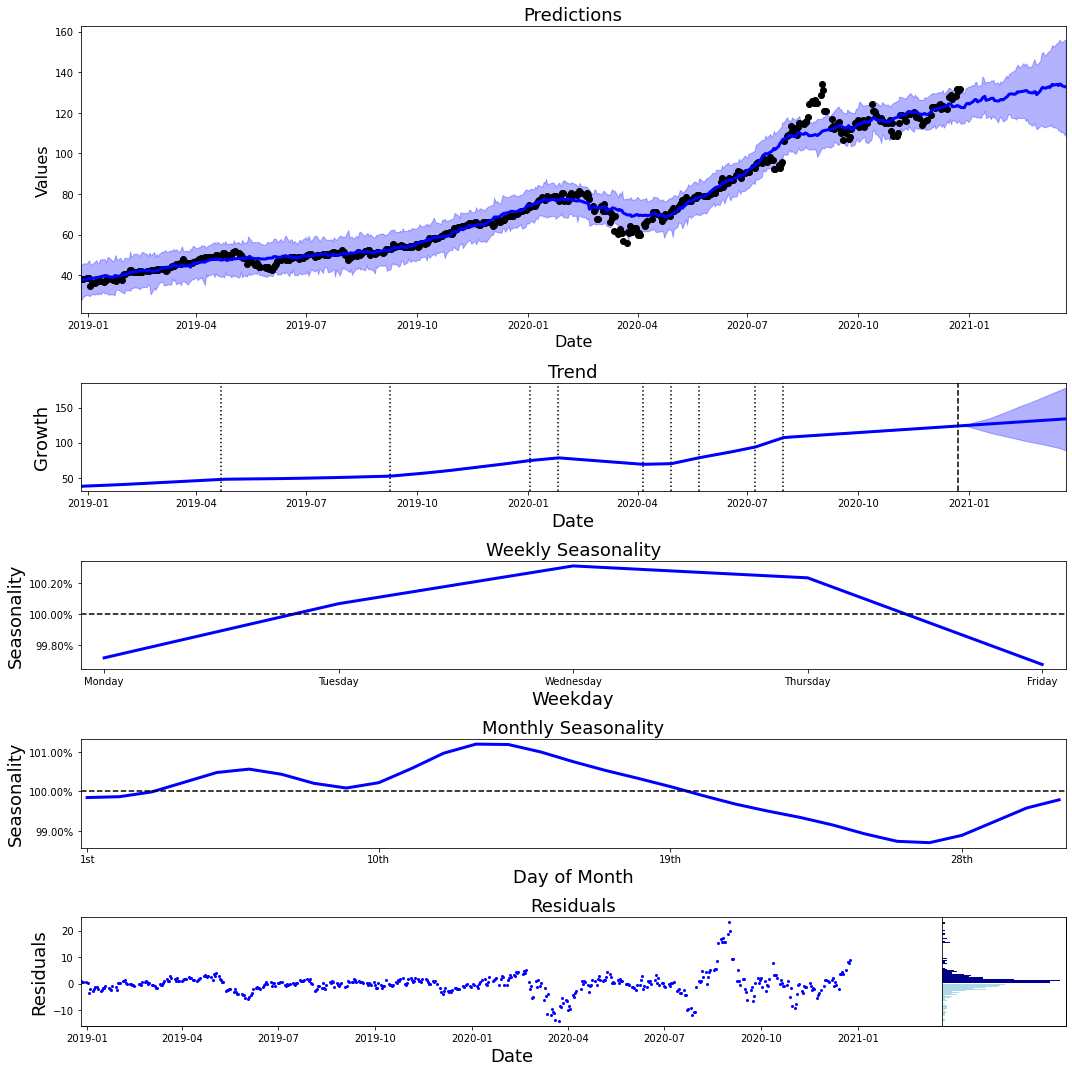

In [47]:
chronos_plotting.plot_components(predictions, my_chronos, figure_name="AAPL.png", changepoint_threshold=0.3);